# Computational Category Theoretic Rewriting 
## Kris Brown, Evan Patterson, Tyler Hanks, and James Fairbanks
This notebook accompanies the above paper, showing the code behind the scenes for each of the main figures.
We start with imports. This relies on new features in Catlab that have not yet been merged into the main branch, so it is important to set one's Catlab version to [here](https://github.com/kris-brown/Catlab.jl/tree/distgraph)

In [1]:
using Revise, Catlab.CategoricalAlgebra, Catlab.Graphs, Catlab.Present, Catlab.Graphics, Catlab.Theories
import Catlab
import Catlab.CategoricalAlgebra.CatElements
using Catlab.CategoricalAlgebra.FinCats: FinCatGraphEq
using CairoMakie
using CombinatorialSpaces
using CombinatorialSpaces.SimplicialSets: get_edge!
using GeometryBasics
import AlgebraicPetri
pres = Catlab.CategoricalAlgebra.CatElements.presentation; # abbreviate long name

## Figure of Section 2.1
An unlabled figure shows an example graph in Catlab. This code can generate a similar figure:

In [3]:
G = @acset Graph begin 
    V=3; E=3; 
    src=[1,2,2]; 
    tgt=[2,3,3] 
end
to_graphviz(G; node_labels=true)

## Figure 2 
The declaration of a new $\mathcal{C}$-set schema and an example instance of that schema.

In [4]:
@present ThSemisimplicialSet(FreeSchema) begin
  (V,E,T) :: Ob
  (d1,d2,d3)::Hom(T,E)
  (src,tgt) :: Hom(E,V)
  compose(d1, src) == compose(d2, src)
  compose(d1, tgt) == compose(d3, tgt)
  compose(d2, tgt) == compose(d3, src)
end
@acset_type SSet(ThSemisimplicialSet)

quadrangle = @acset SSet begin 
    T=2; E=5; V=4
    d1=[1,4]
    d2=[2,3]
    d3=[5,5]
    src=[1,1,2,2,3]
    tgt=[4,3,3,4,4]
end 

SSet with elements V = 1:4, E = 1:5, T = 1:2
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   4 │
│ 2 │   1 │   3 │
│ 3 │   2 │   3 │
│ 4 │   2 │   4 │
│ 5 │   3 │   4 │
└───┴─────┴─────┘
┌───┬────┬────┬────┐
│ T │ d1 │ d2 │ d3 │
├───┼────┼────┼────┤
│ 1 │  1 │  2 │  5 │
│ 2 │  4 │  3 │  5 │
└───┴────┴────┴────┘

Thanks to Andrew Baas, we can visualize SSets with the following function:

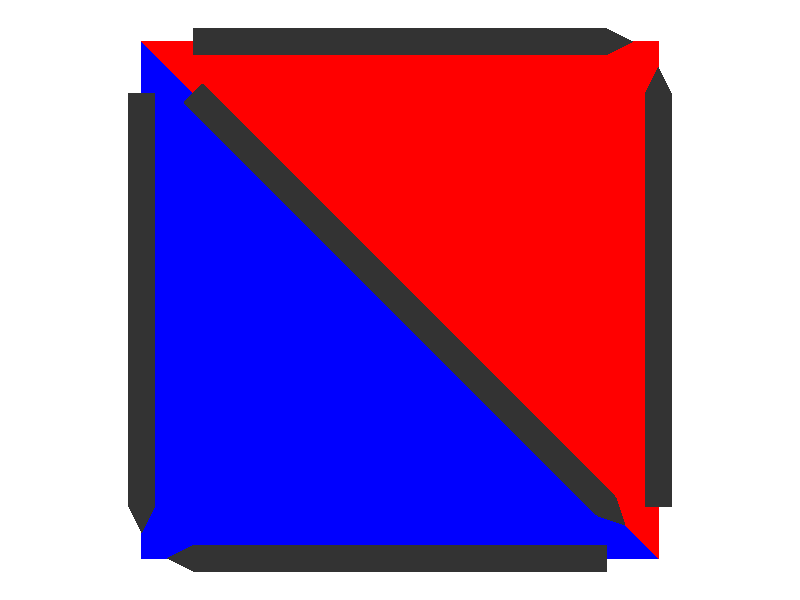

In [50]:
function plot_sset(ss::SSet, points::Vector, 
                   tri_colors::Vector=[:blue,:red,:green, :purple])
    # Validate inputs
    lengthscale=0.8
    dim = length(points[1])
    length(points) == nparts(ss,:V) || error("# of points")
    if dim == 2 
        points = [(p1,p2,0.) for (p1,p2) in points]
    elseif dim != 3
        error("dim $dim")
    end
    tri_colors = tri_colors[1:nparts(ss, :T)]

    # Convert SSet to EmbeddedDeltaSet2D
    s = EmbeddedDeltaSet2D{Bool, Point{3, Float64}}()

    edge_colors = [:black for _ in nparts(ss, :E)]
    add_vertices!(s, length(points), point=points)
    for (src, tgt) in zip(ss[:src], ss[:tgt])
        get_edge!(s, src, tgt)
    end
    
    for t in parts(ss,:T)
    glue_sorted_triangle!(s, ss[t,[:d1,:src]],
                             ss[t,[:d3,:src]],
                             ss[t, [:d1,:tgt]])
    end

    # Split mesh into component triangles
  m = GeometryBasics.Mesh(s)
  x = faces(m)
  m_points = m.position[vcat([[t[1],t[2],t[3]] for t in x]...)]
  m_faces = TriangleFace{Int}[[((t-1) * 3) .+ (1,2,3) for t in  1:length(x)]...]
  new_m = GeometryBasics.Mesh(Point{3, Float64}[m_points...], m_faces)
  fig, ax, ob =  if ntriangles(s) == 0
    fig, ax, ob = arrows((s[s[:∂v0], :point] * (0.5 + lengthscale / 2) .+ s[s[:∂v1], :point] * (0.5 - lengthscale / 2)) , (s[s[:∂v1], :point] .- s[s[:∂v0], :point]), lengthscale=lengthscale, arrowsize=0.05, shininess=0.0,
          color=edge_colors, diffuse=[0.0,0.0,0.0])
  else
    fig, ax, ob = mesh(new_m, color=vcat([[v,v,v] for v in tri_colors]...))
    arrows!((s[s[:∂v0], :point] * (0.5 + lengthscale / 2) .+ s[s[:∂v1], :point] * (0.5 - lengthscale / 2)) , (s[s[:∂v1], :point] .- s[s[:∂v0], :point]), lengthscale=lengthscale, arrowsize=0.05, shininess=0.0,
          color=edge_colors, diffuse=[0.0,0.0,0.0])
    fig, ax, ob
  end
  if dim == 2
  hidespines!(ax)
  hidedecorations!(ax)
  ax.aspect = AxisAspect(1.0) # Remove this line if 3D embedding
    end 
  fig
end
quad_coords = [(0.,0.),(1.,1.),(1.,0.),(0.,1.)]
plot_sset(quadrangle, quad_coords)

## Figure 3a 
Catlab has functionality to reversibly translate between a $\mathcal{C}$-set and its category-of-elements representation (which is a $\mathcal{C}$-typed-graph).

NODE TYPES: [:V, :V, :V, :V, :E, :E, :E, :E, :E, :T, :T]


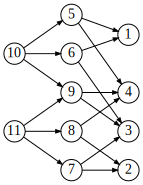

In [6]:
e = elements(quadrangle)
println("NODE TYPES: ", e[[:πₑ, :nameo]])
to_graphviz(FreeDiagram(pres(e)[1]), node_labels=true)

## Figure 4
We show a sequence of building schema `N+1` by choosing a designated instance of schema `N` and treating it as a type system.

In [7]:
G2 = @acset Graph begin V=2; E=2; src=[1,2]; tgt=[2,1] end 
ThPetri = pres(elements(G2))[1]
@acset_type Petri(ThPetri)
Interact = @acset Petri begin 
    V_1=2; V_2=3; E_1=4; E_2=4
    src_E_1 = [1,1,2,2]
    tgt_E_1 = [1,2,2,3]
    src_E_2 = [1,2,2,3]
    tgt_E_2 = [1,1,2,2]
end
ThHV = pres(elements(Interact))[1]
@acset_type HV(ThHV)  ;  
# etc.

## Figure 5
We execute the following code to benchmark the two representations of $\mathcal{C}$-sets.

In [8]:
# INSERT BENCHMARK CODE HERE 

## Figure 6
A single quadralateral edge flip with DPO rewriting. We first set up the objects involved in the rules and the object we will rewrite:

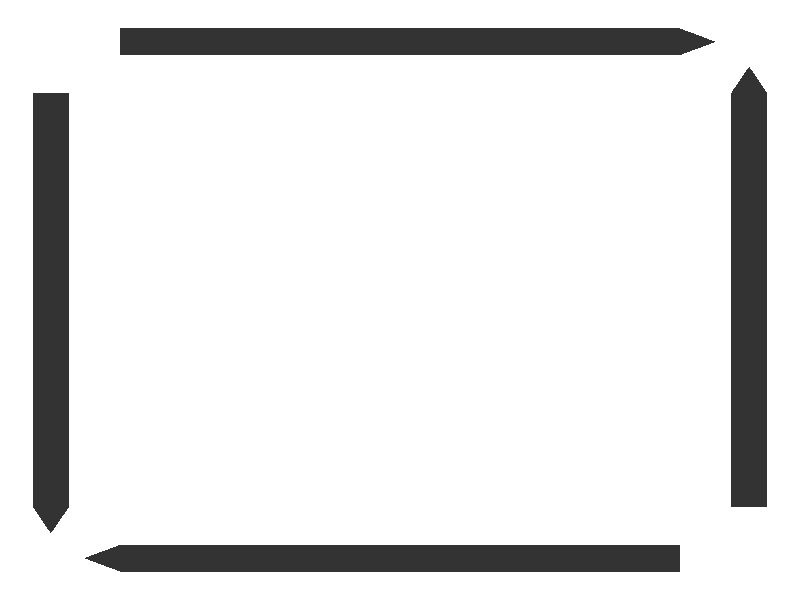

In [38]:
L = quadrangle  # We defined quadrilateral above.
I = @acset SSet begin
  E=4; V=4
  src=[1,1,2,2]
  tgt=[3,4,3,4]
end
plot_sset(I, quad_coords) 


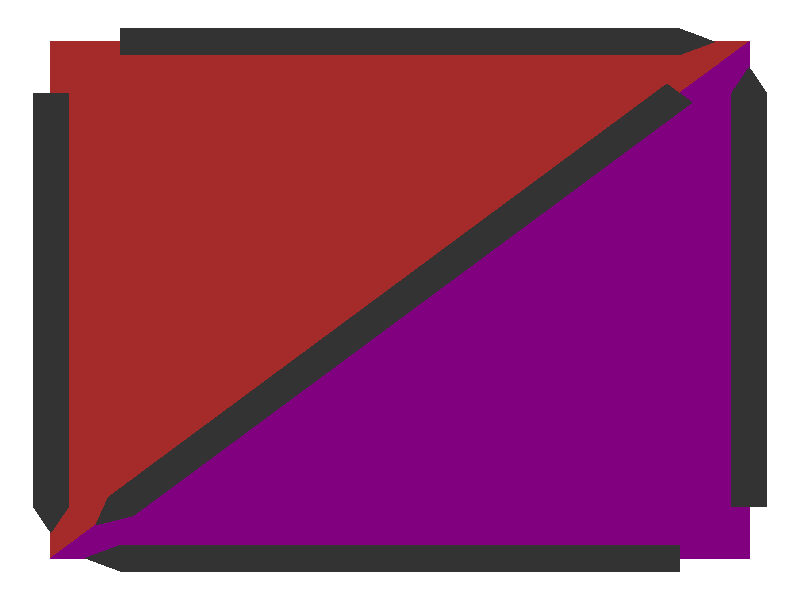

In [10]:
R = @acset SSet begin
  T=2; E=5; V=4
  d1=[2,1]
  d2=[3,3]
  d3=[4,5]
  src=[1,1,1,2,2]
  tgt=[3,4,2,4,3]
end
plot_sset(R, quad_coords, [:brown, :purple])

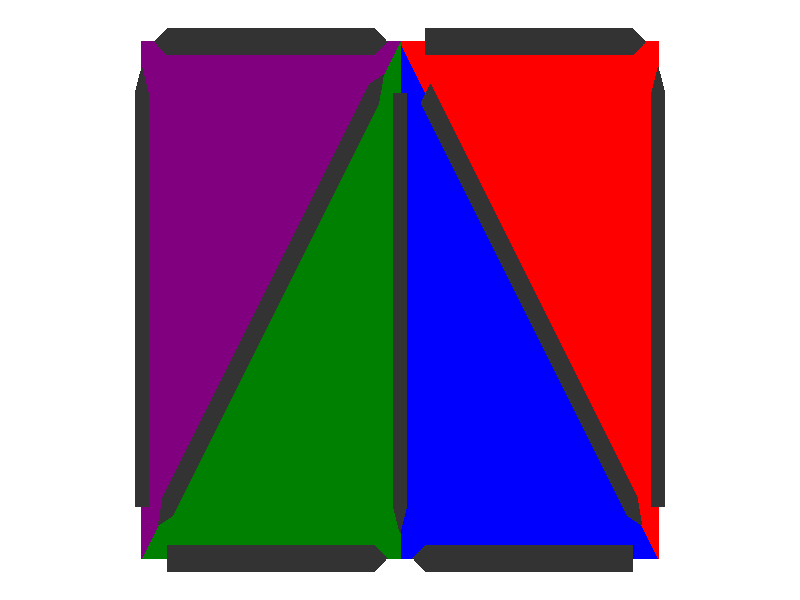

In [66]:
# construct G via pushout: glue two quads by a common edge
edge = @acset SSet begin E=1; V=2; src=[1]; tgt=[2] end 
edge_quad = homomorphism(edge, L; initial=Dict([:V=>[1,4]]))
G = apex(pushout(edge_quad, edge_quad)) 
six_coords = vcat([(0.,0.),(1.,1.),(1.,0.),(0.,1.),(-1.,1.),(-1.,0.),])
plot_sset(G, six_coords)

Partially specify homomorphisms and let automated search handle the rest to generate the morphisms used in DPO.

In [12]:
r = homomorphism(I, R; monic=true)
l = homomorphism(I, L; monic=true)
# Perform rewrite 
rewrite(l, r, G; monic=true) # homomorphism search will find a match, if any

SSet with elements V = 1:6, E = 1:9, T = 1:4
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   3 │
│ 2 │   1 │   4 │
│ 3 │   1 │   2 │
│ 4 │   2 │   4 │
│ 5 │   2 │   3 │
│ 6 │   1 │   6 │
│ 7 │   5 │   6 │
│ 8 │   5 │   4 │
│ 9 │   6 │   4 │
└───┴─────┴─────┘
┌───┬────┬────┬────┐
│ T │ d1 │ d2 │ d3 │
├───┼────┼────┼────┤
│ 1 │  2 │  3 │  4 │
│ 2 │  1 │  3 │  5 │
│ 3 │  2 │  6 │  9 │
│ 4 │  8 │  7 │  9 │
└───┴────┴────┴────┘

## Figure 7
Demonstrating single-pushout rewriting with implicit deletion.

In [13]:
L = @acset SSet begin 
    T=1; E=3; V=3; 
    d1=[1]; d2=[2]; d3=[3]; 
    src=[1,1,2]; tgt=[3,2,3] 
end
l = homomorphism(edge, L)
r = id(edge)
m = homomorphism(L, quadrangle)
!can_pushout_complement(l, m) || error("Check that this does not make sense for DPO")
single_pushout_rewrite(l,r,m)

E,src,tgt
1,1,3
2,2,3


## Figure 8
Demonstrating sesqui-pushout rewriting with implicit copying.

In [14]:
G = @acset SSet begin
  T=1;E=3;V=3;src=[1,1,2];tgt=[3,2,3];d1=[1];d2=[2];d3=[3] 
end
L = @acset SSet begin V=1 end
I = @acset SSet begin V=2 end
l = homomorphism(I,L); 
r=id(I); 
m = CSetTransformation(L, G, V=[1]);

nparts(sesqui_pushout_rewrite(l, r, m), :T)==4 || error("We get 4 'triangles' when we ignore equations")
resSqPO= sesqui_pushout_rewrite(l, r, m; pres=ThSemisimplicialSet)


SSet with elements V = 1:4, E = 1:5, T = 1:2
┌───┬─────┬─────┐
│ E │ src │ tgt │
├───┼─────┼─────┤
│ 1 │   1 │   4 │
│ 2 │   2 │   4 │
│ 3 │   1 │   3 │
│ 4 │   2 │   3 │
│ 5 │   3 │   4 │
└───┴─────┴─────┘
┌───┬────┬────┬────┐
│ T │ d1 │ d2 │ d3 │
├───┼────┼────┼────┤
│ 1 │  1 │  3 │  5 │
│ 2 │  2 │  4 │  5 │
└───┴────┴────┴────┘

## Figure 9
We highlight an aspect of directly rewriting in slice categories by computing the pushout complement of slices. We have special visualization written for Petri nets, so we define a function which migrates a morphism into the graph "2" to a Petri net. But our point is that the computations can be done entirely without moving into this larger schema.  

In [15]:
GraphSlice = Slice{Graph, ACSetTransformation}
GraphSliceMorphism = SliceMorphism{Graph, ACSetTransformation}

function graph_slice(s::GraphSlice) 
    h = s.slice
    V, E = collect.([h[:V], h[:E]])
    g = dom(h)
    (S,T), (I,O) = [[findall(==(i),X) for i in 1:2] for X in [V,E]]
    nS,nT,nI,nO = length.([S,T,I,O])
    findS, findT = [x->findfirst(==(x), X) for X in [S,T]]
    AlgebraicPetri.Graph(@acset AlgebraicPetri.PetriNet begin 
        S=nS; T=nT; I=nI; O=nO
        is=findS.(g[I,:src]); it=findT.(g[I, :tgt])
        ot=findT.(g[O,:src]); os=findS.(g[O, :tgt]) end)
end;

Then we can set up our rewrite problem (given the slice constraint, there is only ever one choice for a map between slices, so we just visualize the objects)

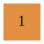

In [16]:
two = @acset Graph begin V=2; E=2; src=[1,2]; tgt=[2,1] end # V1 = (S), V2 = [T]
I_ = Graph(1)
I = GraphSlice(ACSetTransformation(I_, two, V=[2])) # a transition [T]
graph_slice(I)

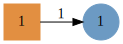

In [17]:
L_ = path_graph(Graph, 2)
L = GraphSlice(ACSetTransformation(L_, two, V=[2,1], E=[2])) # [T] ⟶ (S)
l = GraphSliceMorphism(I,L,ACSetTransformation(I_,L_,V=[1]))
graph_slice(L)

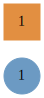

In [18]:
R_ = Graph(2)
R = GraphSlice(ACSetTransformation(R_, two, V=[2, 1])) # a transition and state [T] (S)
r = GraphSliceMorphism(I,R,ACSetTransformation(I_, R_, V=[1]))
graph_slice(R)

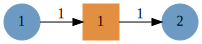

In [19]:
G_ = path_graph(Graph, 3)
G = GraphSlice(ACSetTransformation(G_, two, V=[1,2,1], E=[1,2])) # (S) ⟶ [T] ⟶ (S)
m = GraphSliceMorphism(L,G,ACSetTransformation(L_,G_,V=[2,3], E=[2]))
graph_slice(G)

Now we compute the rewrite in the slice category:

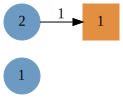

In [20]:
graph_slice(rewrite_match(l, r, m))

## Figure 10
We show an example of computing DPO on structured cospans of Graphs, where the interface type is the discrete graph. We start with an open square, where 1 is the designated input and 2 is the designated output.

input [1] output [2]


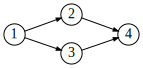

In [21]:
const OpenGraphOb, OpenGraph = OpenCSetTypes(Graph, :V)

# Some basic graphs and morphisms 
G1, G2, G3 = Graph.([1,2,3])
Arrow = path_graph(Graph, 2)
id_1 = id(Graph(1));
f12 = CSetTransformation(G1, G2, V=[1]);
f22 = CSetTransformation(G1, G2, V=[2]);
up_ = ACSetTransformation(G2, Arrow, V=[1,2]);
down_ = ACSetTransformation(G2, G1, V=[1,1]);

# Graph to rewrite
Square = @acset Graph begin V=4; E=4; src=[1,1,2,3]; tgt=[2,3,4,4] end
opensquare = OpenGraph(Square, FinFunction([1], 4), FinFunction([2], 4));

println("input ", collect(first(legs(opensquare))[:V]), 
        " output ", collect(last(legs(opensquare))[:V]),)
to_graphviz(apex(opensquare), node_labels=true)


We then match a rule which squashes an edge into a point, creating an open triangle.

input [1] output [1]


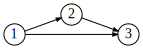

In [22]:
# Discrete open graphs
o1 = OpenGraph(G1, id_1[:V], id_1[:V]);
o2 = OpenGraph(G2, f12[:V], f22[:V]);

# Open graph with an edge 
openarr = OpenGraph(Arrow, f12[:V], f22[:V]);


# Map from discrete 2 point graph to an arrow, so we delete the arrow
squash_l = StructuredMultiCospanHom(o2, openarr,
  ACSetTransformation[up_, id_1, id_1])

# Map from discrete 2 point graph to the discrete 1 point graph
squash_r = StructuredMultiCospanHom(o2, o1,
  ACSetTransformation[down_, id_1, id_1])

# Putting together the two legs of the rule
squash = openrule(Span(squash_l, squash_r))

# match arrow to square edge that has an input and an output
square_m = StructuredMultiCospanHom(openarr, opensquare,
  ACSetTransformation[
        ACSetTransformation(Arrow, Square, V=[1,2], E=[1]), 
  id_1, id_1])

# Input and output now merged
res = open_rewrite_match(squash, square_m)
println("input ", collect(first(legs(res))[:V]), 
        " output ", collect(last(legs(res))[:V]),)
to_graphviz(apex(res), node_labels=true)


## Figure 11
We show the construction of a cube surface as a distributed semi-simplicial set. Start by defining the category of distributed Semisimplicial Sets as a special kind of diagram


In [23]:
const ACSetCat{S} = TypeCat{S, ACSetTransformation}
const DistACSet{S,D} = Diagram{id, ACSetCat{S}, D}
const DistACSetHom{S, F,Φ,D} = DiagramHom{id, ACSetCat{S},F,Φ,D}

const DistSSet{D} = DistACSet{ACSetCat{SSet}, D}
const DistSSetHom{F,Φ,D} = DistACSetHom{ACSetCat{SSet},F,Φ,D}

DiagramHom{Catlab.Theories.id, TypeCat{TypeCat{SSet, ACSetTransformation}, ACSetTransformation}, F, Φ, D} where {F, Φ, D}

We then specify the data of the network graph and declare its path to commute. 

In [24]:
""" 
Helper fn: category generated by a finite graph where all paths commute.
"""
function CommutingGraph(g::HasGraph)
  pths = vcat([zip(ps, ps[2:end]) for ps in values(enumerate_paths(g))
              if length(ps) > 1]...)
  FinCatGraphEq(g, ((x,y)->x=>y).(pths)) # all possible equations
end

d = @acset Graph begin 
    V=6+12;  # faces, edges: numbering comes from the figure →,↓
    E=24;    # each face glued along four edges
    src=[2,2,3,3, 5,5, 6,6, 7,7, 8,8, 9,9, 11,11,13,13,15,15,16,16,17,17]
    tgt=[1,4,1,10,1,14,4,10,4,12,4,14,1,18,10,12,12,14,10,18,12,18,14,18]
end;
to_graphviz(d, node_labels=true);

D = CommutingGraph(d)

FinCat(Graph:
  V = 1:18
  E = 1:24
  src : E → V = [2, 2, 3, 3, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 11, 11, 13, 13, 15, 15, 16, 16, 17, 17]
  tgt : E → V = [1, 4, 1, 10, 1, 14, 4, 10, 4, 12, 4, 14, 1, 18, 10, 12, 12, 14, 10, 18, 12, 18, 14, 18], [])

Lastly, we construct the functor into the category of semisimplicial complexes


In [25]:

# SSets corresponding to the vertices
obs = vcat(repeat([quadrangle], 6), repeat([edge], 12))

# Use homomorphism finder to get all of the relevant morphisms
purple, red, green, teal, _ = homomorphisms(edge, quadrangle) # TODO: actually get this right

# SSet morphisms corresponding to the edges of the diagram
homs = [green, green,  # E2
        red, green,    # E3
        teal, green,   # E5
        teal, red,     # E6
        purple, green, # E7
        red, teal,     # E8
        purple, green, # E9
        purple, red,   # E11
        teal, purple,  # E13
        teal, red,     # E15
        purple, purple,# E16
        red, teal]     # E17
J = Diagram(FinDomFunctor(obs, homs, D)); 